In [1]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

In [2]:
#import errors
df = pd.read_csv("utk_face_predictions.csv")

#drop colunmns
df = df.drop(["Unnamed: 0", "date&time", "filename"], axis=1)
df["race"] = df["race"].replace({0:"White", 1:"Black", 2:"Asian", 3:"Indian", 4:"Other"})
#Others includes Hispanic, Latino, Middle Eastern
print(df.shape)
df.head()

(9778, 4)


,age,gender,race,pre_age
0,100,1,White,52
1,100,1,Asian,39
2,101,1,Asian,37
3,10,0,White,30
4,10,0,White,30


In [3]:
#baseline MAE error
df_error = df.copy()
df_error["diff"] = df["age"] - df["pre_age"]
df_error["abs_diff"] = df_error["diff"].abs()
MAE_baseline = df_error["abs_diff"].mean()

#baseline RMSE error
def square(x):
    return x**2
df_error["sq_diff"] = df_error["diff"].apply(square)
MSE_baseline = df_error["sq_diff"].mean()
RMSE_baseline = math.sqrt(MSE_baseline)

#print errors
print("Baseline MAE: ", MAE_baseline)
print("Baseline MSE: ", MSE_baseline)
print("Baseline RMSE", RMSE_baseline)

Baseline MAE:  17.379320924524443
Baseline MSE:  429.53784004908977
Baseline RMSE 20.725294691489665


## Correcting Overall Bias for Age based on just original predicted age

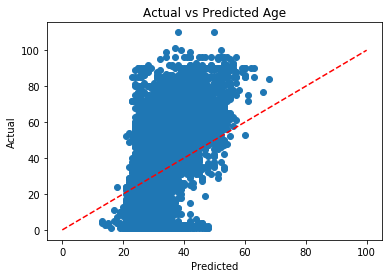

In [4]:
#Set up the data, check scatter
X = np.array(df["pre_age"])
X = np.reshape(X, (-1, 1))

r = range(0,101)
Y = df["age"]
Y = np.array(Y)
plt.scatter(X, Y)
plt.plot(r, r, color = 'red', linestyle = "--")
plt.xlabel('Predicted') 
plt.ylabel('Actual')
plt.title("Actual vs Predicted Age")
plt.show()

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.30, random_state = 11)

#### Linear Regression

In [6]:
linear = LinearRegression()
linear.fit(X_train, Y_train)
Y_pred = linear.predict(X_test)
mae = mean_absolute_error(Y_test, Y_pred)
rmse = math.sqrt(mean_squared_error(Y_test, Y_pred))

print("Intercept: " + str(linear.intercept_) + "     Coef: " + str(linear.coef_))
print("MAE : " + str(round(mae,5)))
print("RMSE : " + str(round(rmse,5)))

Intercept: -43.340337681980515     Coef: [2.35887827]
MAE : 14.75916
RMSE : 18.79284


#### Random Forest

In [7]:
RandomForestRegressorModel = RandomForestRegressor(n_estimators=50)
RandomForestRegressorModel.fit(X_train, Y_train)
Y_pred = RandomForestRegressorModel.predict(X_test)
mae = mean_absolute_error(Y_test, Y_pred)
rmse = math.sqrt(mean_squared_error(Y_test, Y_pred))

print("MAE : " + str(round(mae,5)))
print("RMSE : " + str(round(rmse,5)))

MAE : 14.44419
RMSE : 18.57074


## Correcting Bias using orig predicted age, actual gender and actual race

In [8]:
#set up data
X = pd.get_dummies(df,prefix=["race"]).drop(["age"], axis=1)
Y = df["age"]
X.head()

,gender,pre_age,race_Asian,race_Black,race_Indian,race_Other,race_White
0,1,52,0,0,0,0,1
1,1,39,1,0,0,0,0
2,1,37,1,0,0,0,0
3,0,30,0,0,0,0,1
4,0,30,0,0,0,0,1


In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.30, random_state = 11)

#### Linear Regression

In [10]:
linear = LinearRegression()
linear.fit(X_train, Y_train)
Y_pred = linear.predict(X_test)
mae = mean_absolute_error(Y_test, Y_pred)
rmse = math.sqrt(mean_squared_error(Y_test, Y_pred))

print("Intercept: " + str(linear.intercept_) + "     Coef: " + str(linear.coef_))
print("MAE : " + str(round(mae,5)))
print("RMSE : " + str(round(rmse,5)))

Intercept: -39.20933954621596     Coef: [-1.11058848  2.19624922 -5.51939937  4.36701246 -0.15231882 -3.64505594
  4.94976167]
MAE : 14.38492
RMSE : 18.36849


#### Random Forest

In [11]:
RandomForestRegressorModel = RandomForestRegressor(n_estimators=50)
RandomForestRegressorModel.fit(X_train, Y_train)
Y_pred = RandomForestRegressorModel.predict(X_test)
mae = mean_absolute_error(Y_test, Y_pred)
rmse = math.sqrt(mean_squared_error(Y_test, Y_pred))

print("MAE : " + str(round(mae,5)))
print("RMSE : " + str(round(rmse,5)))

MAE : 14.06905
RMSE : 18.34446


#### Polynomial

In [18]:
#Fit data to a polynomial 
mae_list = []
rmse_list = []
poly_list = [2,3,4,5]

for p in poly_list:
    poly = PolynomialFeatures(degree=p)
    X_train_P = poly.fit_transform(X_train)
    X_test_P = poly.fit_transform(X_test)

    #run model
    reg = linear_model.LinearRegression()
    reg.fit(X_train_P, Y_train)
    y_pred_x_test_P = reg.predict(X_test_P)
    # print("Coef: " + str(reg.coef_))
    # print("Intercept: " + str(reg.intercept_))

    #Analyze model fit
    mae = mean_absolute_error(Y_test, y_pred_x_test_P)
    rmse = math.sqrt(mean_squared_error(Y_test, y_pred_x_test_P))
    mae_list.append(mae)
    rmse_list.append(rmse)  

best_poly = (np.argmin(rmse_list)+2)
    
print("MAEs: ")
print(*mae_list)
print("RMSEs: ")
print(*rmse_list)
print("Best polynomial is: ", best_poly)

MAEs: 
14.152082712080489 14.079486017563617 14.030760437850189 14.040899235587057
RMSEs: 
18.257208494340794 18.227919662325853 18.218502035094488 18.330414107349814
Best polynomial is:  4


In [22]:
#Predict new values of Y for all X's using model
poly = PolynomialFeatures(degree=best_poly)
X_P = poly.fit_transform(X)
#run model
reg = linear_model.LinearRegression()
reg.fit(X_P, Y)
y_new = pd.Series(reg.predict(X_P))
y_new = y_new.rename('revised_prediction')

df_new = pd.concat([df["age"], y_new], axis=1)
df_new.head()

,age,revised_prediction
0,100,72.457984
1,100,49.347002
2,101,42.889555
3,10,32.933700
4,10,32.933700


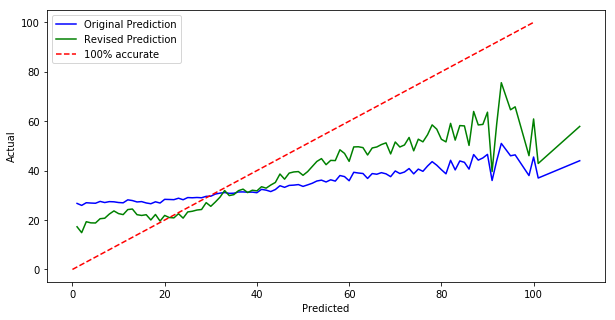

In [25]:
#Plot averages for each age prediction against actual age
plt.figure(figsize=(10,5))

dmean = df.groupby(['age'], as_index=False)['pre_age'].mean()
dmean_new = df_new.groupby(['age'], as_index=False)['revised_prediction'].mean()
x_orig = dmean['age']
y_orig = dmean['pre_age']
x_new = dmean_new['age']
y_new = dmean_new['revised_prediction']

plt.plot(x_orig, y_orig, color = 'b', label = "Original Prediction")
plt.plot(x_new, y_new, color = 'g', label = "Revised Prediction")
plt.plot(r, r, color = 'red', linestyle = "--", label = "100% accurate") 
plt.xlabel('Predicted') 
plt.ylabel('Actual')
plt.legend(numpoints=1, loc='best')
plt.show()